In [1]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit_num_clus_pro as toy
import matplotlib.pyplot as plt

import scipy.stats as stats



In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99500317e+002 2.62139880e-001 1.37561024e-004 ... 6.35986003e-319
  2.51973479e-322 0.00000000e+000]
 [4.99001370e+002 5.23506860e-001 5.49205579e-004 ... 2.89955856e-284
  3.04971525e-287 3.20351438e-290]
 ...
 [2.78359318e+000 2.84437375e+000 2.90570097e+000 ... 1.97133509e+001
  2.03015070e+001 2.09216123e+001]
 [2.77900802e+000 2.83988115e+000 2.90130497e+000 ... 1.97643931e+001
  2.03546617e+001 2.09769895e+001]
 [2.77442406e+000 2.83538944e+000 2.89690957e+000 ... 1.98155610e+001
  2.04079486e+001 2.10325060e+001]]
(9700, 100)


In [3]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


[0.33763902]


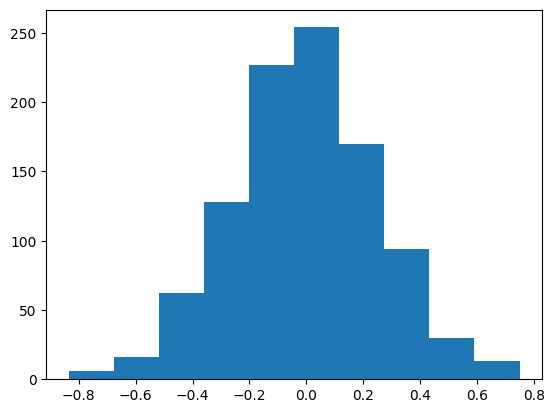

In [17]:

a=-4
b=4
print(stats.truncnorm.rvs(a, b, size=1))

a=-4
b=4
plt.hist(stats.truncnorm.rvs(a, b, loc=0, scale=0.25, size=1000))
plt.show()

In [18]:
a=-4
b=4


noise = 1
values = org_values * noise * (1 + stats.truncnorm.rvs(a, b, loc=0, scale=0.25, size=1))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_49532/4188123613.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.2
1     162     0:08.8
2     312     0:10.2
3     453     0:10.8
20    2301    0:20.4
40    4665    0:32.8
60    7158    0:47.7
80    9591    1:00.4
100   12153   1:14.4
120   14685   1:27.4
140   17310   1:40.9
160   19890   1:54.5
180   22710   2:09.6
200   25458   2:23.9
220   28185   2:38.2
240   30735   2:51.3
260   33252   3:04.4
280   36336   3:21.5
300   41094   3:46.6
320   45591   4:10.4
340   49458   4:30.4
360   53541   4:51.9
380   57153   5:11.0
400   61332   5:32.5
420   66213   5:57.7
440   70659   6:21.3
460   74769   6:42.9
480   78993   7:04.4
500   83058   7:25.9
520   87216   7:46.9
540   91089   8:06.5
560   94980   8:26.8
580   99642   8:50.3
600   104256   9:14.4
620   109068   9:39.4
640   113541  10:04.7
660   117834  10:27.7
680   122277  10:50.3
700   126891  11:15.3
720   131391  11:38.9
740   135888  12:02.6
760   140325  12:26.8
780   1

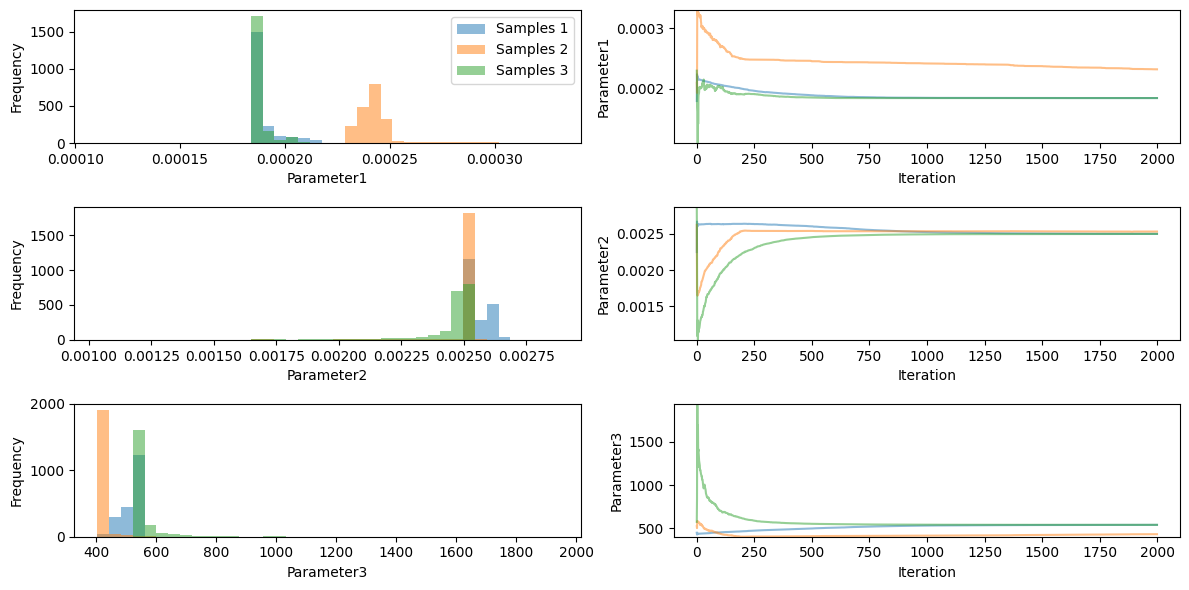

<class '__main__.MyMCMCSummary'>
param    mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
-------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b        0.000202  2.48e-05  0.000185  0.000185  0.000185  0.000235  0.000242  33      12.8   0.00651
p        0.00251   1.59e-05  0.0025    0.0025    0.00251   0.00253   0.00254   7.13    9.69   0.00493
N        501       54.5      417       428       539       541       542       36.9    9.24   0.0047


In [19]:
pints.plot.trace(chains)
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_49532/3711519685.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     207     0:06.0
2     309     0:07.5
3     402     0:08.1
20    1977    0:17.9
40    3690    0:29.4
60    6255    0:44.5
80    8901    0:57.9
100   11619   1:11.9
120   14280   1:25.9
140   16836   1:40.7
160   19362   1:53.5
180   21924   2:07.1
200   24462   2:20.6
220   27159   2:34.5
240   29907   2:49.2
260   32607   3:02.8
280   35343   3:19.5
300   38142   3:34.8
320   40785   3:48.6
340   43404   4:02.4
360   45963   4:15.9
380   48594   4:30.2
400   51288   4:44.5
420   54006   4:59.7
440   56511   5:13.2
460   59106   5:27.2
480   61719   5:41.0
500   64365   5:56.1
520   67071   6:11.3
540   69738   6:27.5
560   72447   6:42.0
580   75132   6:55.9
600   77934   7:11.0
620   80589   7:25.2
640   83328   7:40.4
660   85938   7:54.4
680   88689   8:08.7
700   91290   8:23.1
720   93987   8:36.8
740   96585   8:49.8
760   99462   9:04.5
780   102504   9

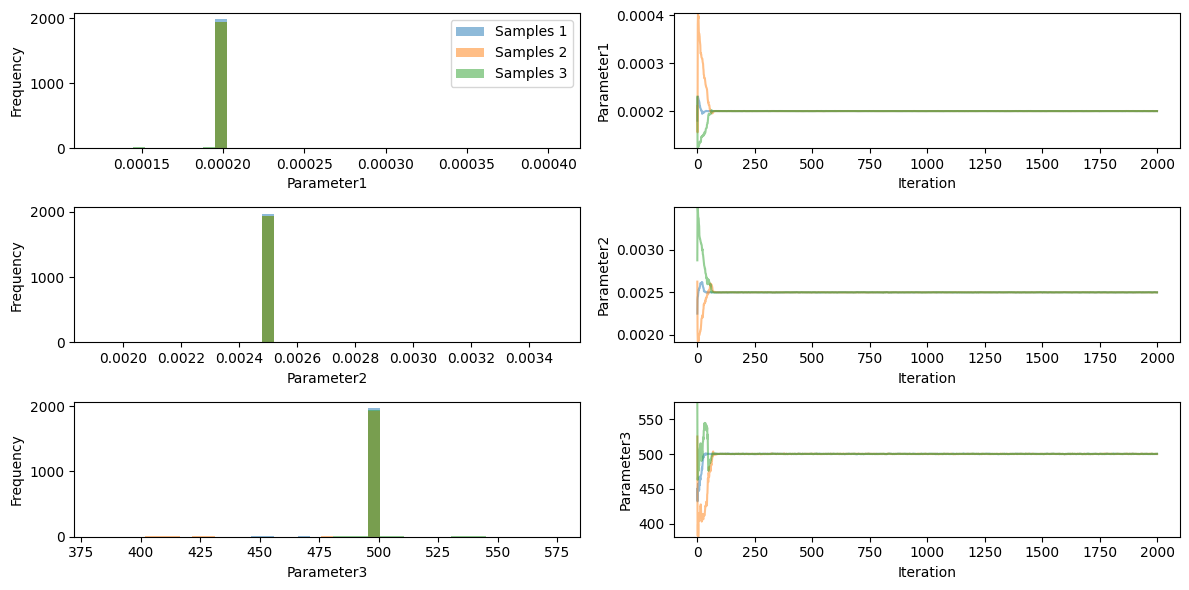

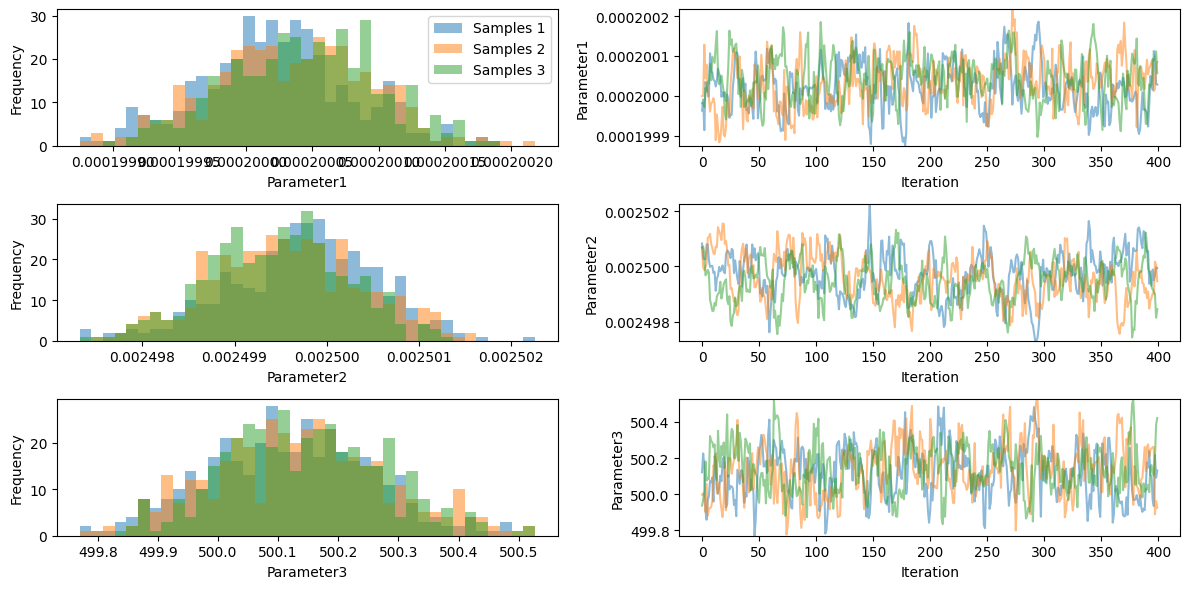

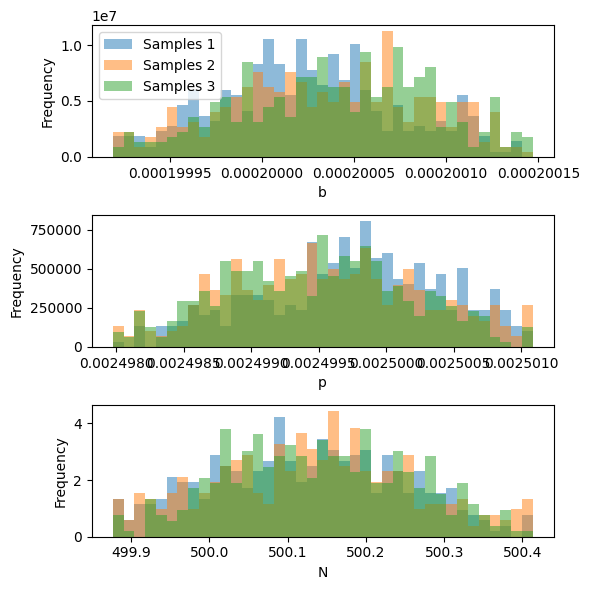

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  5.74e-08  0.0002  0.0002  0.0002  0.0002  0.0002   1.03    195    0.138
p        0.0025  7.87e-07  0.0025  0.0025  0.0025  0.0025  0.0025   1.04    137    0.0968
N        500     0.139     500     500     500     500     500      1.02    178    0.126


In [20]:
noise = 10
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains_3 = mcmc.run()

print(chains_3)

ITERS = 2000
print(3*ITERS/4)

pints.plot.trace(chains_3)
plt.savefig("noisy_data_noise_10_additive_full_distribution.png")
plt.show()

pints.plot.trace(chains_3[:,int(4*ITERS/5):, :])
# plt.savefig("noisy_data_additive_full_distribution.png")
plt.show()

pints.plot.histogram(chains_3[:,int(4*ITERS/5):, :], kde=False, n_percentiles=95, parameter_names=parameter_names)
plt.savefig("hist_only_noisy_data_noise_10_additive_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains_3[:,int(3*ITERS/4):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)